In [1]:
cd("Test_1/notebooks/")

Base.IOError: IOError: cd("Test_1/notebooks/"): no such file or directory (ENOENT)

In [2]:
import Pkg; Pkg.activate(".")

  Activating project at `/sps/nemo/scratch/mpetro/Projects/PhD/TrackReconstructionTests/Test_1/notebooks`


In [232]:
# Add the necessary packages if not added yet.
Pkg.add(["UnROOT", "DataFrames", "StatsPlots", "FHist", "StatsBase", "Distributions", "Turing", "LinearAlgebra", "Optim", "LaTeXStrings", "Measurements"])

In [233]:
using UnROOT, DataFrames, StatsPlots, FHist, StatsBase, Distributions, Turing, StatsBase, LinearAlgebra, Optim, LaTeXStrings, Measurements

In [6]:
theme(:dao)

In [7]:
# load root file
f2nu = ROOTFile("../data/CAT/bb2nu/bb2nu_1M_events.root")

ROOTFile with 1 entry and 20 streamers.
../data/CAT/bb2nu/bb2nu_1M_events.root
└─ tree (TTree)
   ├─ "phi"
   ├─ "reconstructedEnergy1"
   ├─ "reconstructedEnergy2"
   ├─ "⋮"
   ├─ "x2Escaped"
   ├─ "y2Escaped"
   └─ "z2Escaped"


In [8]:
# extract reconstructed vertex positions into dataframe
df = LazyTree(f2nu, "tree", ["x1Escaped","y1Escaped","z1Escaped","x2Escaped","y2Escaped","z2Escaped", "reconstructedEnergy1", "reconstructedEnergy2"]) |> DataFrame

Row,reconstructedEnergy2,reconstructedEnergy1,z2Escaped,z1Escaped,x1Escaped,x2Escaped,y2Escaped,y1Escaped
,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32
1,1252.12,266.487,714.631,806.767,0.125,0.125,767.457,742.369
2,430.865,242.098,318.109,247.598,-0.125,0.125,-1579.93,-1578.16
3,1167.66,936.986,485.689,507.298,-0.125,0.125,-2354.63,-2356.58
4,653.914,828.57,942.329,930.672,-0.125,-0.125,-1631.48,-1600.08
5,714.987,310.712,751.06,674.58,-0.125,-0.125,1954.95,2047.05
6,731.787,256.442,504.398,519.394,-0.125,-0.125,1342.81,1314.22
7,222.459,275.182,-922.604,-954.686,-0.125,0.125,-1287.56,-1268.58
8,687.987,386.905,443.187,475.86,0.125,0.125,-1063.82,-1060.92
9,606.218,916.842,366.338,392.883,-0.125,0.125,-617.717,-604.947


In [9]:
# quick glance at what's inside
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float32,Float32,Float64,Float32,Int64,DataType
1,reconstructedEnergy2,589.085,50.0057,532.387,2390.61,0,Float32
2,reconstructedEnergy1,583.216,50.0165,527.478,2249.56,0,Float32
3,z2Escaped,0.623519,-1349.93,-1.09586,1349.87,0,Float32
4,z1Escaped,0.514242,-1349.93,1.11341,1349.66,0,Float32
5,x1Escaped,-0.0751014,-0.125,-0.125,0.125,0,Float32
6,x2Escaped,0.075424,-0.125,0.125,0.125,0,Float32
7,y2Escaped,-1.84506,-2488.42,5.32332,2486.42,0,Float32
8,y1Escaped,-1.61488,-2482.05,5.71547,2455.46,0,Float32


# Analysis:

### The goal here is to create 3 histograms:
1. 1D histogram of $\Delta y$
2. 1D histogram of $\Delta z$
3. 2D histogram of $\Delta d_{zy}$

### For each histogram we fit and extract 68% credible interval (interpreted as sigma):

In [10]:
# transform df to get Δy, Δz, d data
begin
	df.dy = df.y1Escaped .- df.y2Escaped
	df.dz = df.z1Escaped .- df.z2Escaped
	df.dyz = @. sqrt( df.dy^2 + df.dz^2)
	df
end

Row,reconstructedEnergy2,reconstructedEnergy1,z2Escaped,z1Escaped,x1Escaped,x2Escaped,y2Escaped,y1Escaped,dy,dz,dyz
,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32,Float32
1,1252.12,266.487,714.631,806.767,0.125,0.125,767.457,742.369,-25.0878,92.136,95.4905
2,430.865,242.098,318.109,247.598,-0.125,0.125,-1579.93,-1578.16,1.76648,-70.5106,70.5327
3,1167.66,936.986,485.689,507.298,-0.125,0.125,-2354.63,-2356.58,-1.94824,21.6094,21.6971
4,653.914,828.57,942.329,930.672,-0.125,-0.125,-1631.48,-1600.08,31.3994,-11.6565,33.4932
5,714.987,310.712,751.06,674.58,-0.125,-0.125,1954.95,2047.05,92.0992,-76.4803,119.714
6,731.787,256.442,504.398,519.394,-0.125,-0.125,1342.81,1314.22,-28.5972,14.996,32.2905
7,222.459,275.182,-922.604,-954.686,-0.125,0.125,-1287.56,-1268.58,18.9751,-32.0811,37.2726
8,687.987,386.905,443.187,475.86,0.125,0.125,-1063.82,-1060.92,2.8949,32.6732,32.8012
9,606.218,916.842,366.338,392.883,-0.125,0.125,-617.717,-604.947,12.7696,26.5446,29.4563


## Now that the important data is generated, let's take a look at what the dy, dz, dyz look like:

  1. We can see that for each variable there are outlier values (take a look at the max and compare to mean a median) 
  2. Comparing the mean and median values for dy and dz shows that a larger error is to be expected in dz compared to dy
  

In [11]:
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float32,Float32,Float64,Float32,Int64,DataType
1,reconstructedEnergy2,589.085,50.0057,532.387,2390.61,0,Float32
2,reconstructedEnergy1,583.216,50.0165,527.478,2249.56,0,Float32
3,z2Escaped,0.623519,-1349.93,-1.09586,1349.87,0,Float32
4,z1Escaped,0.514242,-1349.93,1.11341,1349.66,0,Float32
5,x1Escaped,-0.0751014,-0.125,-0.125,0.125,0,Float32
6,x2Escaped,0.075424,-0.125,0.125,0.125,0,Float32
7,y2Escaped,-1.84506,-2488.42,5.32332,2486.42,0,Float32
8,y1Escaped,-1.61488,-2482.05,5.71547,2455.46,0,Float32
9,dy,0.230179,-1574.7,0.00195312,2976.47,0,Float32


## Concerning the outlier values: 
- let's take a look at how many outlier there are by studying the quantiles of dy and dz
- [TO DO] we should take a look in flvisualize at these events and figure out what's happening! (Should figure out a way of getting the event ID of the outliers)

In [12]:
alpha = 0.995
lq, uq = (1.0 - alpha)/2.0, 1.0-(1.0-alpha)/2.0
@show dy_995q = quantile(df.dy, [lq, uq])
@show dz_995q = quantile(df.dz, [lq, uq])

dy_995q = quantile(df.dy, [lq, uq]) = [-218.74821441650352, 238.11192306518763]
dz_995q = quantile(df.dz, [lq, uq]) = [-205.99728309631337, 198.35308837891122]


2-element Vector{Float64}:
 -205.99728309631337
  198.35308837891122

## It can be seen that 99.5% of events have vertices reconstructed that fall well within the range of say ~ (-240, 240) - it should be safe to ignore the crazy outliers and use this the binning of -240:240 

In [13]:
# drop outliers:

filter!(row -> -240.0 < row.dy < 240.0 &&  -240.0 < row.dz < 240.0, df);

In [142]:
h1dy = StatsBase.fit(Histogram{Float32}, df.dy, -240.0:5:240.0)
h1dz = StatsBase.fit(Histogram{Float32}, df.dz, -205.0:5:205.0)

Histogram{Float32, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  -205.0:5.0:205.0
weights: Float32[15.0, 23.0, 22.0, 29.0, 26.0, 25.0, 39.0, 28.0, 57.0, 44.0  …  41.0, 44.0, 41.0, 22.0, 33.0, 21.0, 22.0, 22.0, 21.0, 23.0]
closed: left
isdensity: false

In [143]:
rms(v::Vector{<:Real}) = std(v; corrected=:false, mean=0)

rms (generic function with 1 method)

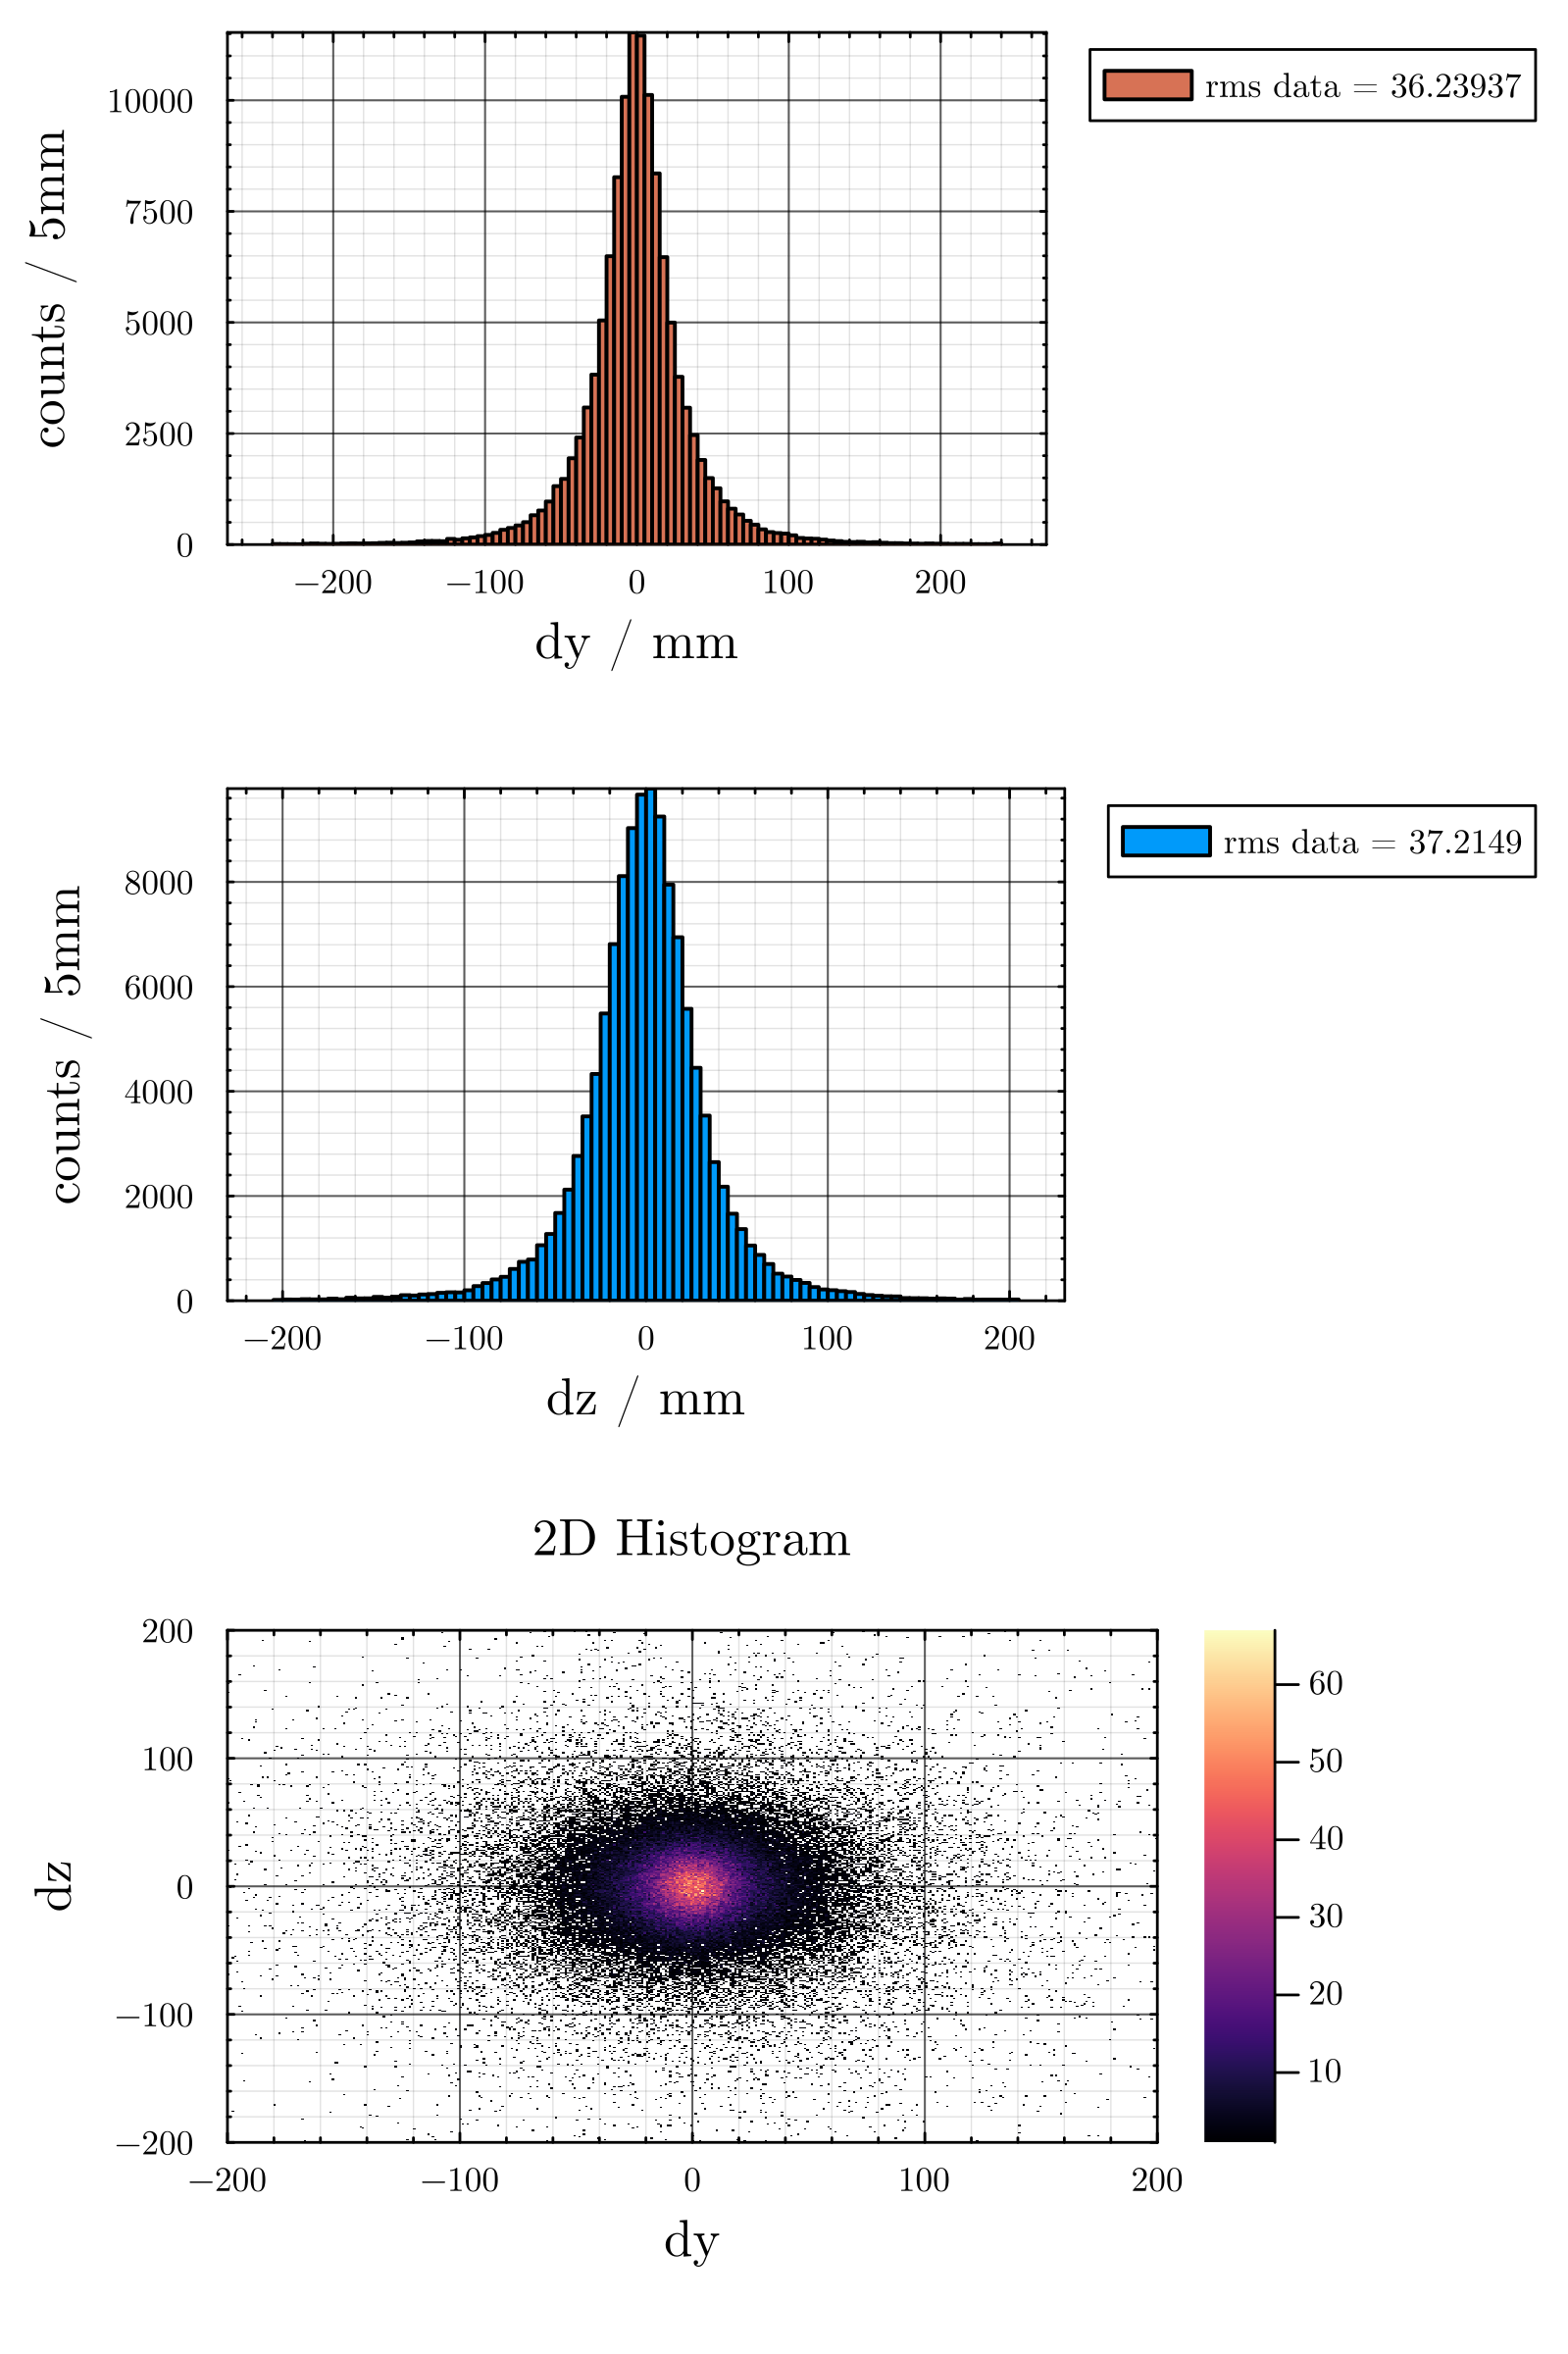

In [144]:
let 
	p1 = plot(h1dy, xlabel = "dy / mm", ylabel ="counts / 5mm", label ="rms data = $(rms(df.dy))", c=1)
	p2 = plot(h1dz, xlabel = "dz / mm", ylabel ="counts / 5mm", label ="rms data = $(rms(df.dz))", c=2)
	p3 = histogram2d(df.dy, df.dz, bins = (-200:200,-200:200), aspect =1, xlabel ="dy", ylabel="dz", title="2D Histogram")
	plot(p1, p2, p3, layout=grid(3,1), size = (800,1200), thickness_scaling= 1.4, dpi =200)
	savefig("../plots/CAT_2nubb.png")
	current()
end

## Now we fit the distributions to extract 68% credible interval - to be used as sigma uncertainty (?)

- For dy we use Cauchy distribution 
- For dz we use Normal distribution

## Create model for Turing

In [205]:
@model function model_dy(dy)
	μ ~ Normal(0, 0.1)
	σ ~ Uniform(1e-5, 1e3)
	dy .~ Cauchy(μ, σ)
end

model_dy (generic function with 2 methods)

In [206]:
@model function model_dz(dz)
	μ ~ Normal(0, 0.1)
	σ ~ Uniform(1e-5, 1e3)
	dz .~ Cauchy(μ, σ)
end

model_dz (generic function with 2 methods)

## Create chain object used in MCMC

In [207]:
# sample with metropolis-hastings, we create 10^4 samples per chain, 4 chains:
optim_dy = optimize(model_dy(df.dy), MLE(), NelderMead())
chain_dy = Turing.sample(model_dy(df.dy), MH(), 1000, init_params = optim_dy.values.array)

Chains MCMC chain (1000×3×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 4.0 seconds
Compute duration  = 4.0 seconds
parameters        = μ, σ
internals         = lp

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

           μ    0.0132    0.0070     0.0002    0.0011    7.4140    1.0979      ⋯
           σ   14.8364    0.0023     0.0001    0.0004    7.4140    1.0979      ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           μ   -0.0096    0.0154    0.0154    0.0154    0.0154
           σ   14.8357   14.8357   14.8357   14.8357   14.8438


In [208]:
optim_dz = optimize(model_dz(df.dz), MLE(), NelderMead())
chain_dz = Turing.sample(model_dz(df.dz), MH(), 1000, init_params=optim_dz.values.array)

Chains MCMC chain (1000×3×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 3.77 seconds
Compute duration  = 3.77 seconds
parameters        = μ, σ
internals         = lp

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

           μ    0.1051    0.0000     0.0000    0.0000    2.6738    0.9990      ⋯
           σ   16.6465    0.0000     0.0000    0.0000    2.6738    0.9990      ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           μ    0.1051    0.1051    0.1051    0.1051    0.1051
           σ   16.6465   16.6465   16.6465   16.6465   16.6465


In [225]:
# now we extract the fitted parameters:
(mu_dy, sigma_dy) = mean(chain_dy[:,1,:]), mean(chain_dy[:,2,:])
(mu_dz, sigma_dz) = mean(chain_dz[:,1,:]), mean(chain_dz[:,2,:])

(0.10509085398766331, 16.646476272736784)

In [210]:
# fit functions for plotting:
fit_function_dy( mu_dy, sigma_dy, x ) = pdf( Cauchy(mu_dy, sigma_dy), x )
fit_function_dz( mu_dz, sigma_dz, x ) = pdf( Cauchy(mu_dz, sigma_dz), x )

fit_function_dz (generic function with 1 method)

In [211]:
"""
    r-squared coefficient of fit as defined in (https://en.wikipedia.org/wiki/Coefficient_of_determination)
"""
function r2(fit_function, histogram)
    yᵢ = histogram.weights
    xᵢ = collect( midpoints(histogram.edges[1]) )
    fᵢ = fit_function.(xᵢ)
    ybar = mean(yᵢ)

    SStot = sum( (yᵢ .- ybar).^2 )
    SSres = sum( (yᵢ .- fᵢ).^2 )

    return 1-( SSres / SStot)
end

r2

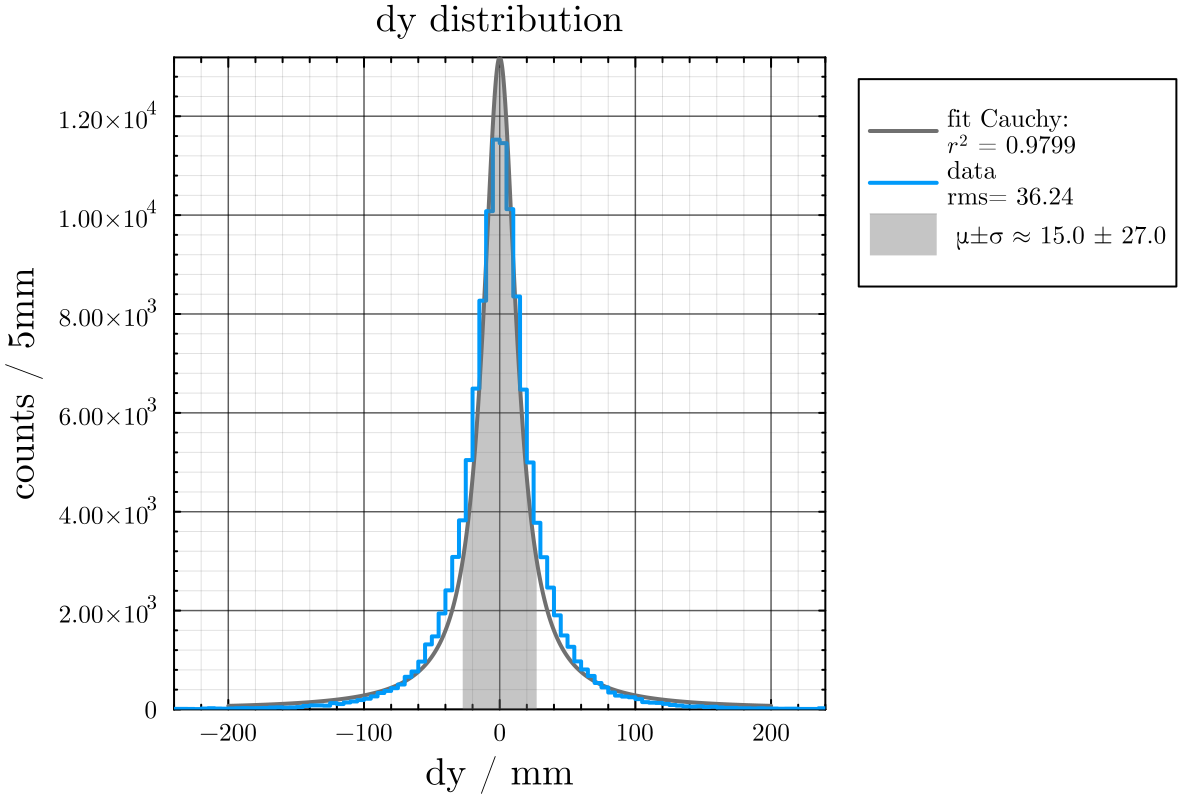

In [277]:
fdy(x) = step(h1dy.edges[1])*nrow(df)*fit_function_dy( mu_dy, sigma_dy, x )

pmSigmady = quantile(Cauchy(mu_dy, sigma_dy), [0.15865, 0.84135]) # [0.15865, 0.84135] is equal to ±σ quantiles
mu_pm_sigma_dy = sigma_dy ± pmSigmady[2] # get the mean value plus/minus 1 sigma as a measurement

plot(-200:0.1:200, x-> fdy(x), label ="fit Cauchy: \n"* L"r^2"* " = $(round(r2(fdy, h1dy), sigdigits=4))", lw =2, c=3, title="dy distribution", dpi =200)
plot!(h1dy , xlabel = "dy / mm", ylabel ="counts / 5mm", label ="data \nrms= $(round(rms(df.dy), digits=2))", c=2, lw = 2, st=:step, widen =:false)
plot!( pmSigmady[1]:0.1:pmSigmady[2], x-> fdy(x), lw = 0, f = 0, fa =0.4, c=3, label =" μ±σ ≈ $( mu_pm_sigma_dy )" )

In [278]:
savefig( "../plots/CAT_dy_cauchy_fit.png" )

"/sps/nemo/scratch/mpetro/Projects/PhD/TrackReconstructionTests/Test_1/plots/CAT_dy_cauchy_fit.png"

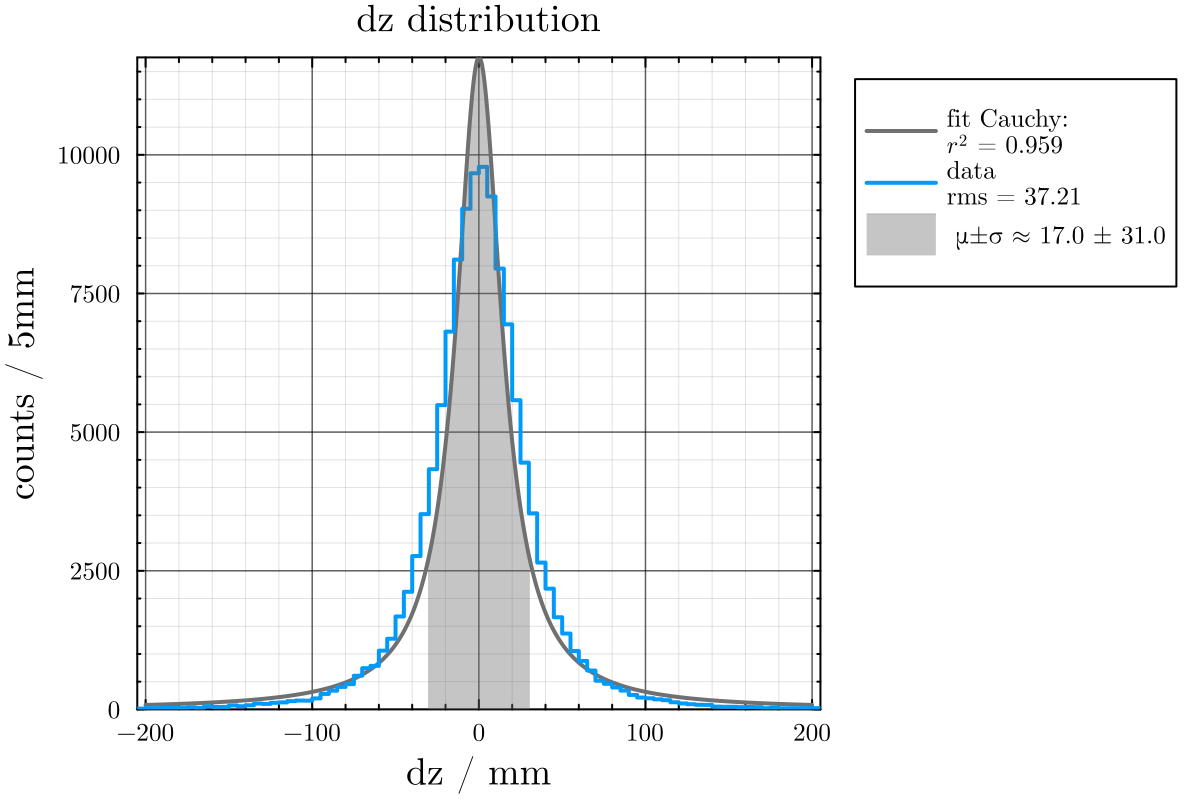

In [275]:
fdz(x) = step(h1dz.edges[1])*nrow(df)*fit_function_dz( mu_dz, sigma_dz, x )

pmSigmadz = quantile(Cauchy(mu_dz, sigma_dz), [0.15865, 0.84135]) # [0.15865, 0.84135] is equal to ±σ quantiles
mu_pm_sigma_dz = sigma_dz ± pmSigmadz[2] # get the mean value plus/minus 1 sigma as a measurement

plot(-200:0.1:200, x-> fdz(x), label ="fit Cauchy: \n"* L"r^2"* " = $(round(r2(fdz, h1dz), sigdigits=4))", lw =2, c = 3, title="dz distribution", dpi = 200)
plot!(h1dz , xlabel = "dz / mm", ylabel ="counts / 5mm", label ="data \nrms = $(round(rms(df.dz), digits=2))", c=2, st = :step, lw= 2, widen=:false)
plot!( pmSigmadz[1]:0.1:pmSigmadz[2], x-> fdz(x), lw = 0, f = 0, fa =0.4, c = 3, label =" μ±σ ≈ $( mu_pm_sigma_dz )" )


In [276]:
savefig( "../plots/CAT_dz_cauchy_fit.png" )

"/sps/nemo/scratch/mpetro/Projects/PhD/TrackReconstructionTests/Test_1/plots/CAT_dz_cauchy_fit.png"

# Finally we find that the uncertainty on the CAT vertex reconstruction precision is:
* $\sigma_y \approx 27.3 mm$ with $rms_y = 36.2 mm$ 
* $\sigma_z \approx 30.1 mm$ with $rms_z = 37.2 mm$ 